# Modules

In [3]:
!git clone https://github.com/niazwazir/LICENCE_PLATE_RECOGNITION.git

Cloning into 'LICENCE_PLATE_RECOGNITION'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 6 (delta 1), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (6/6), done.


In [4]:
!ls

LICENCE_PLATE_RECOGNITION  sample_data


In [5]:
cd LICENCE_PLATE_RECOGNITION

/content/LICENCE_PLATE_RECOGNITION


In [6]:
!ls

LICENCE_PLATE_RECOGNITION.ipynb  vehicle-number-plate-detection.zip


In [7]:
!unzip vehicle-number-plate-detection.zip

Archive:  vehicle-number-plate-detection.zip
  inflating: Indian_Number_plates.json  


In [8]:
!ls

Indian_Number_plates.json	 vehicle-number-plate-detection.zip
LICENCE_PLATE_RECOGNITION.ipynb


In [9]:
import pandas as pd
from urllib import request
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt

from keras.applications.vgg16 import VGG16
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Input, Dropout
from keras.models import Model, Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

Using TensorFlow backend.


# Data Processing

In [10]:
df_json = pd.read_json('Indian_Number_plates.json', lines=True)
df_json.head()

,content,annotation,extras
0,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",NaN
1,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",NaN
2,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",NaN
3,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",NaN
4,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",NaN


In [0]:
dataset = {'image_name':list(),
           'top_x':list(),
           'top_y':list(),
           'bottom_x':list(),
           'bottom_y':list(),
           'image_width':list(),
           'image_height':list()}

In [0]:
!mkdir Data

In [13]:
!ls

Data			   LICENCE_PLATE_RECOGNITION.ipynb
Indian_Number_plates.json  vehicle-number-plate-detection.zip


In [0]:
num=1
for i, row in df_json.iterrows():
    url = row['content']
    img = request.urlopen(url)
    img = Image.open(img)
    img = img.convert('RGB')
    img.save('Data/{}.jpeg'.format(num), 'JPEG')
    dataset['image_name'].append(str(num)+'.jpeg')
    
    annot = row['annotation'][0]
    dataset['image_width'].append(annot['imageWidth'])
    dataset['image_height'].append(annot['imageHeight'])
    dataset['top_x'].append(annot['points'][0]['x'])
    dataset['top_y'].append(annot['points'][0]['y'])
    dataset['bottom_x'].append(annot['points'][1]['x'])
    dataset['bottom_y'].append(annot['points'][1]['y'])
    
    num += 1

In [15]:
df = pd.DataFrame(dataset)
df.head()

,image_name,top_x,top_y,bottom_x,bottom_y,image_width,image_height
0,1.jpeg,0.722084,0.587983,0.868486,0.688841,806,466
1,2.jpeg,0.161943,0.850780,0.582996,1.000000,494,449
2,3.jpeg,0.082000,0.697452,0.230000,0.828025,500,314
3,4.jpeg,0.434000,0.667377,0.718000,0.765458,500,469
4,5.jpeg,0.208791,0.390764,0.865135,0.984014,1001,563


In [0]:
df.to_csv('dataset.csv', index=False)

In [17]:
df = pd.read_csv('dataset.csv')
df.drop(['image_width', 'image_height'], axis=1, inplace=True)
df.head()

,image_name,top_x,top_y,bottom_x,bottom_y
0,1.jpeg,0.722084,0.587983,0.868486,0.688841
1,2.jpeg,0.161943,0.850780,0.582996,1.000000
2,3.jpeg,0.082000,0.697452,0.230000,0.828025
3,4.jpeg,0.434000,0.667377,0.718000,0.765458
4,5.jpeg,0.208791,0.390764,0.865135,0.984014


In [0]:
test_samples = np.random.randint(0, len(df), 5)
df_train = df.drop(test_samples, axis=0)

In [0]:
def show_image(index):
    img = cv2.imread('Data/' + df['image_name'].iloc[index])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, dsize=(224,224))
    
    tx = int(df['top_x'].iloc[index] * 224)
    ty = int(df['top_y'].iloc[index] * 224)
    bx = int(df['bottom_x'].iloc[index] * 224)
    by = int(df['bottom_y'].iloc[index] * 224)
    
    img = cv2.rectangle(img, (tx, ty), (bx, by), (255,0,0), 1)
    plt.imshow(img)
    plt.show()

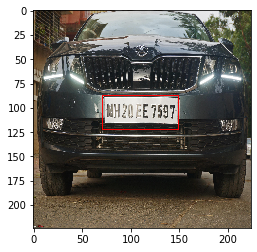

In [20]:
show_image(34)

# Model

In [21]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.1)

train_generator = datagen.flow_from_dataframe(
    df_train,
    directory="Data/",
    x_col="image_name",
    y_col=["top_x", "top_y", "bottom_x", "bottom_y"],
    target_size=(224, 224),
    batch_size=32, 
    class_mode="other",
    subset="training")

validation_generator = datagen.flow_from_dataframe(
    df_train,
    directory="Data/",
    x_col="image_name",
    y_col=["top_x", "top_y", "bottom_x", "bottom_y"],
    target_size=(224, 224),
    batch_size=32, 
    class_mode="other",
    subset="validation")

Found 209 validated image filenames.
Found 23 validated image filenames.


In [22]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))





58892288/58889256 [==============================] - 1s 0us/step








In [0]:
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(4, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [24]:
for layer in base_model.layers:
    layer.trainable = False
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [0]:
train_step_size = int(np.ceil(train_generator.n / train_generator.batch_size))
val_step_size = int(np.ceil(validation_generator.n / validation_generator.batch_size))

train_generator.reset()
validation_generator.reset()

In [26]:
print(train_step_size, val_step_size)

7 1


# Training

In [27]:
adam = Adam(lr=0.0005)
model.compile(optimizer=adam, loss='mse', metrics=['accuracy'])

In [28]:
history = model.fit_generator(train_generator,
                             steps_per_epoch=train_step_size,
                             epochs=30,
                             validation_data=validation_generator,
                             validation_steps=val_step_size)



Epoch 1/30
7/7 [==============================] - 15s 2s/step - loss: 0.0483 - acc: 0.4730 - val_loss: 0.0261 - val_acc: 0.7391
Epoch 2/30
7/7 [==============================] - 1s 152ms/step - loss: 0.0155 - acc: 0.7215 - val_loss: 0.0208 - val_acc: 0.7826
Epoch 3/30
7/7 [==============================] - 2s 257ms/step - loss: 0.0077 - acc: 0.7427 - val_loss: 0.0125 - val_acc: 0.6957
Epoch 4/30
7/7 [==============================] - 2s 238ms/step - loss: 0.0040 - acc: 0.8816 - val_loss: 0.0125 - val_acc: 0.6522
Epoch 5/30
7/7 [==============================] - 2s 255ms/step - loss: 0.0026 - acc: 0.9009 - val_loss: 0.0146 - val_acc: 0.7391
Epoch 6/30
7/7 [==============================] - 2s 255ms/step - loss: 0.0021 - acc: 0.9020 - val_loss: 0.0123 - val_acc: 0.6957
Epoch 7/30
7/7 [==============================] - 2s 237ms/step - loss: 0.0013 - acc: 0.9255 - val_loss: 0.0124 - val_acc: 0.6957
Epoch 8/30
7/7 [==============================] - 2s 254ms/step - loss: 0.0011 - acc: 0.93

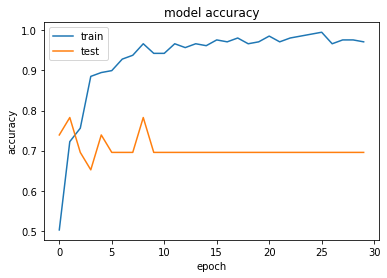

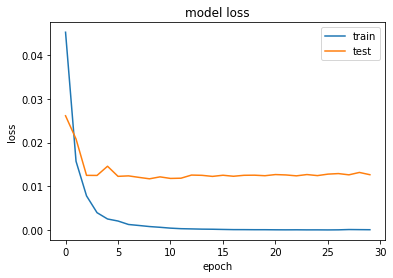

In [29]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc='best')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc='best')
plt.show()

# Test

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


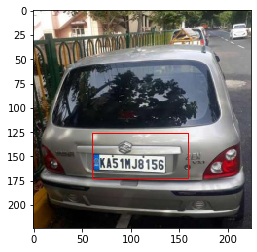

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


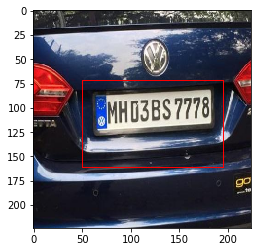

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


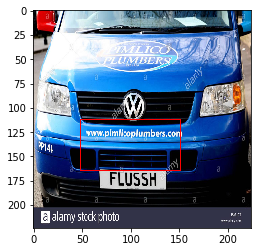

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


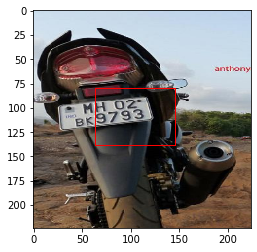

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


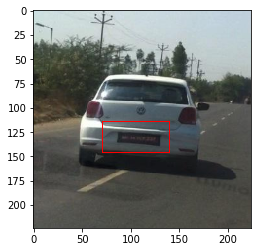

In [30]:
for i, row in df.iloc[test_samples].iterrows():
    img = cv2.imread('Data/' + row[0])
    img = cv2.resize(img/255.0, dsize=(224,224))
    
    y_pred = model.predict(img.reshape(1, 224, 224, 3)).reshape(-1) * 224
    
    x_top, y_top, x_bottom, y_bottom = y_pred[0], y_pred[1], y_pred[2], y_pred[3]
    
    img = cv2.cvtColor(img.astype(np.float32), cv2.COLOR_BGR2RGB)
    img = cv2.rectangle(img, (x_top, y_top), (x_bottom, y_bottom), (255,0,0), 1)
    plt.imshow(img)
    plt.show()